# CNV Analysis

In [1]:
import cPickle
import datetime
import glob
import os
import random
import re
import subprocess

import cdpybio as cpb
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import pybedtools as pbt
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import tabix
import vcf as pyvcf

import cardipspy as cpy
import ciepy

%matplotlib inline

dy_name = 'cnv_analysis'

import socket
if socket.gethostname() == 'fl-hn1' or socket.gethostname() == 'fl-hn2':
    dy = os.path.join(ciepy.root, 'sandbox', 'tmp', dy_name)
    cpy.makedir(dy)
    pbt.set_tempdir(dy)
    
outdir = os.path.join(ciepy.root, 'output', dy_name)
cpy.makedir(outdir)

private_outdir = os.path.join(ciepy.root, 'private_output', dy_name)
cpy.makedir(private_outdir)

In [2]:
transcript_to_gene = pd.read_table(cpy.gencode_transcript_gene, header=None, 
                                   squeeze=True, index_col=0)
gene_info = pd.read_table(cpy.gencode_gene_info, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'eqtl_input', 
                  'tpm_log_filtered_phe_std_norm_peer_resid.tsv')
exp = pd.read_table(fn, index_col=0)

dy = os.path.join(ciepy.root, 'output/eqtl_processing/eqtls01')
fn = os.path.join(dy, 'qvalues.tsv')
qvalues = pd.read_table(fn, index_col=0)
fn = os.path.join(dy, 'lead_variants.tsv')
lead_vars = pd.read_table(fn, index_col=0)
lead_vars = lead_vars[lead_vars.perm_sig]
fn = os.path.join(dy, 'gene_variant_pairs.tsv')
gene_variant = pd.read_table(fn, index_col=0)

fn = os.path.join(ciepy.root, 'output/cnv_processing/gs_info.pickle')
gs_info = cPickle.load(open(fn))
fn = os.path.join(ciepy.root, 'private_output/cnv_processing/gs_genotypes.tsv')
gs_geno = pd.read_table(fn, index_col=0)

fn = os.path.join(ciepy.root, 'output/cnv_processing/lumpy_info.pickle')
lumpy_info = cPickle.load(open(fn))
fn = os.path.join(ciepy.root, 'private_output/cnv_processing/lumpy_genotypes.tsv')
lumpy_geno = pd.read_table(fn, index_col=0)

fn = os.path.join(ciepy.root, 'output/cnv_processing/combined_info.pickle')
combined_info = cPickle.load(open(fn))
combined_info = combined_info[combined_info.emmax]

gene_bt = pbt.BedTool(cpy.gencode_gene_bed)

# fn = os.path.join(ciepy.root, 'output', 'cnv_processing', 'encode_dnase_overlap.tsv')
# encode_dnase_overlap = pd.read_table(fn, index_col=0)
# fn = os.path.join(ciepy.root, 'output', 'cnv_processing', 'gs_encode_tf_chip_seq_overlap.tsv')
# gs_encode_chip_overlap = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'cnv_processing', 'gs_roadmap_overlap.tsv')
gs_roadmap_overlap = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'cnv_processing', 'lumpy_roadmap_overlap.tsv')
lumpy_roadmap_overlap = pd.read_table(fn, index_col=0)

# fn = os.path.join(ciepy.root, 'private_output', 'cnv_processing', 'emmax_cnvs.tsv')
# emmax_cnvs = pd.read_table(fn, index_col=0)

I have to reverse the sign of LUMPY deletions because people who are het for a lumpy deletion
have one less copy number than reference and people are homo alt have two less copy number than
reference. All other CNVs are encoded where alts are increasing copy number.

In [4]:
cnv_lead_vars = lead_vars[lead_vars.variant_type == 'cnv']
cnv_lead_vars['cnv_id'] = cnv_lead_vars.marker_id.apply(lambda x: '_'.join(x.split('_')[2:]))
cnv_lead_vars['svtype'] = combined_info.ix[cnv_lead_vars.cnv_id, 'svtype'].values
ind = cnv_lead_vars[(cnv_lead_vars.variant_caller == 'lumpy') & 
                    (cnv_lead_vars.svtype == 'DEL')].index
cnv_lead_vars.ix[ind, 'beta'] = cnv_lead_vars.ix[ind, 'beta'] * -1

cnv_gv = gene_variant[gene_variant.variant_type == 'cnv']
cnv_gv['cnv_id'] = cnv_gv.marker_id.apply(lambda x: '_'.join(x.split('_')[2:]))

In [6]:
print('{:,} distinct CNVs we could test (maybe didn\'t test all).'.format(combined_info.shape[0]))
a = len(set(cnv_lead_vars.gene_id))
b = len(set(cnv_lead_vars.marker_id))
print('{} eQTLs with CNV as lead variant ({} distinct CNVs).'.format(a, b))
a = cnv_gv.shape[0]
b = len(set(cnv_gv.gene_id))
c = len(set(cnv_gv.marker_id))
print('{:,} gene-CNV associations for {} genes and {} CNVs.'.format(a, b, c))

16,506 distinct CNVs we could test (maybe didn't test all).
111 eQTLs with CNV as lead variant (116 distinct CNVs).
1,388 gene-CNV associations for 422 genes and 847 CNVs.


In [7]:
cnv_gv['cnv_is_lead'] = cnv_gv.gene_id.apply(lambda x: x in cnv_lead_vars.gene_id.values)
lead_vars['cnv_is_lead'] = lead_vars.gene_id.apply(lambda x: x in cnv_lead_vars.gene_id.values)
lead_vars['cnv_sig'] = lead_vars.gene_id.apply(lambda x: x in cnv_gv.gene_id.values)

In [8]:
a = len(set(gene_variant.gene_id))
b = len(set(gene_variant.ix[gene_variant.variant_type != 'cnv', 'gene_id']))
print('{} eGenes would have been missed if CNVs were not included'.format(a - b))

31 eGenes would have been missed if CNVs were not included


## GO enrichment

In [9]:
fn = os.path.join(outdir, 'go_results.tsv')
if not os.path.exists(fn):
    t = pd.Series(False, set(gene_variant.gene_id))
    t[set(cnv_gv.gene_id)] = True
    go_res = cpb.analysis.goseq_gene_enrichment(
        [x.split('.')[0] for x in t.index],
        t.values, 
        plot_fn=None, 
        length_correct=False)
    go_res.to_csv(fn, sep='\t')
else:
    go_res = pd.read_table(fn, index_col=0)

In [10]:
go_res[['over_represented_pvalue', 'term', 'over_represented_pvalue_bh']].head()

,over_represented_pvalue,term,over_represented_pvalue_bh
category,,,
GO:0016840,0.003099,carbon-nitrogen lyase activity,1
GO:0001306,0.003153,age-dependent response to oxidative stress,1
GO:0004111,0.003153,creatine kinase activity,1
GO:0007571,0.003153,age-dependent general metabolic decline,1
GO:0016842,0.003153,amidine-lyase activity,1


## Effect sizes

TODO: I'd like to simplify the plot and stats tests below.

TODO: I need to account for the lumpy CNVs when looking at the direction
of effect. I'm guessing for lumpy del's I need to reverse the direction of 
effect to make 0/1/2 genotypes correlate with increasing copy number.

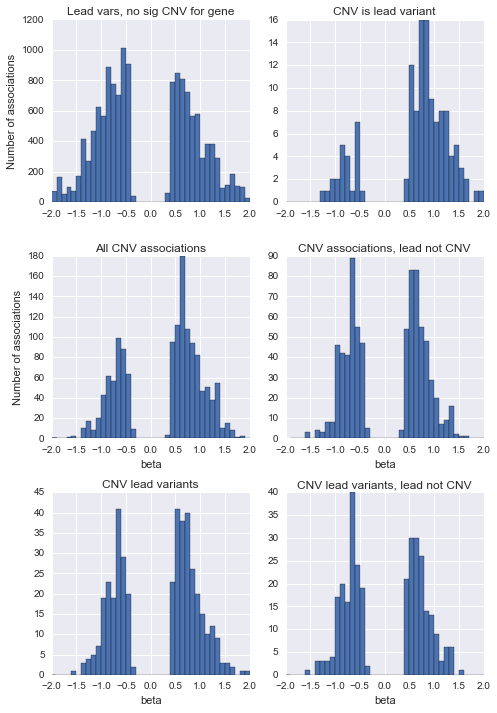

In [12]:
fig,axs = plt.subplots(3, 2, figsize=(7, 10))

# Lead variants, no sig CNV
ax = axs[0, 0]
lead_vars[lead_vars.cnv_sig == False].beta.hist(ax=ax, bins=np.arange(-2, 2.1, 0.1))
ax.set_xlim(-2, 2)
ax.set_ylabel('Number of associations')
ax.set_title('Lead vars, no sig CNV for gene')

# CNV is lead variant
ax = axs[0, 1]
# For lumpy deletions, having an alt alleles means lower copy number, so I need
# to reverse the beta values.
se = cnv_lead_vars.beta
ind = cnv_lead_vars[(cnv_lead_vars.variant_caller == 'lumpy') & 
                    (cnv_lead_vars.marker_id.apply(lambda x: 'DEL' in x))].index
se[ind] = -se[ind]
se.hist(ax=ax, bins=np.arange(-2, 2.1, 0.1))
ax.set_xlim(-2, 2)
ax.set_title('CNV is lead variant')

# All CNV associations
ax = axs[1, 0]
se = cnv_gv.beta
ind = cnv_gv[(cnv_gv.variant_caller == 'lumpy') & 
             (cnv_gv.marker_id.apply(lambda x: 'DEL' in x))].index
se[ind] = -se[ind]
se.hist(ax=ax, bins=np.arange(-2, 2.1, 0.1))
ax.set_xlim(-2, 2)
ax.set_ylabel('Number of associations')
ax.set_xlabel('beta')
ax.set_title('All CNV associations')

# All CNV associations for genes where CNV is not the lead
ax = axs[1, 1]
se = cnv_gv.beta
ind = cnv_gv[(cnv_gv.variant_caller == 'lumpy') & 
             (cnv_gv.marker_id.apply(lambda x: 'DEL' in x))].index
se[ind] = -se[ind]
se = se[cnv_gv.cnv_is_lead == False]
se.hist(ax=ax, bins=np.arange(-2, 2.1, 0.1))
ax.set_xlim(-2, 2)
ax.set_xlabel('beta')
ax.set_title('CNV associations, lead not CNV')
ax = axs[2, 0]
cnv_gv.sort_values('pvalue').drop_duplicates('gene_id').beta.hist(ax=ax, bins=np.arange(-2, 2.1, 0.1))
ax.set_xlim(-2, 2)
ax.set_xlabel('beta')
ax.set_title('CNV lead variants')
ax = axs[2, 1]
cnv_gv[cnv_gv.cnv_is_lead == False].sort_values('pvalue').drop_duplicates('gene_id').beta.hist(
    ax=ax, bins=np.arange(-2, 2.1, 0.1))
ax.set_xlim(-2, 2)
ax.set_xlabel('beta')
ax.set_title('CNV lead variants, lead not CNV')
plt.tight_layout()

In [13]:
cnv_lead_vars.sort_values(by='pvalue', inplace=True)
lead_vars.sort_values(by='pvalue', inplace=True)

In [14]:
cnv_abs_beta_pdf = pd.Series(index=np.arange(0, 3 + 0.05, 0.05))
density = stats.gaussian_kde(cnv_lead_vars.drop_duplicates('gene_id').beta.abs())
cnv_abs_beta_pdf = pd.Series(density(cnv_abs_beta_pdf.index), index=cnv_abs_beta_pdf.index)
snv_abs_beta_pdf = pd.DataFrame(index=np.arange(0, 3 + 0.005, 0.005))
density = stats.gaussian_kde(lead_vars[lead_vars.cnv_sig == False].drop_duplicates('gene_id').beta.abs())
snv_abs_beta_pdf = pd.Series(density(snv_abs_beta_pdf.index), index=snv_abs_beta_pdf.index)

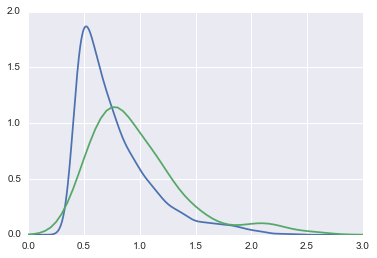

In [15]:
snv_abs_beta_pdf.plot()
cnv_abs_beta_pdf.plot()

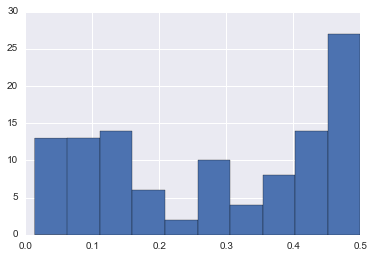

In [16]:
cnv_lead_vars.drop_duplicates('gene_id').maf.hist()

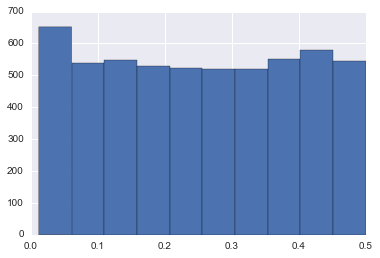

In [17]:
lead_vars[lead_vars.cnv_is_lead == False].drop_duplicates('gene_id').maf.hist()

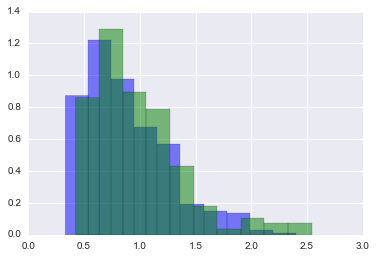

In [18]:
lead_vars[lead_vars.cnv_sig == False].beta.abs().hist(color='blue', alpha=0.5, normed=True)
cnv_lead_vars.beta.abs().hist(color='green', alpha=0.5, normed=True)

In [19]:
s,p = stats.mannwhitneyu(lead_vars[lead_vars.cnv_sig == False].beta.abs(),
                         cnv_lead_vars.beta.abs())
s,p

(780422.0, 0.0031457480602911287)

In [20]:
s,p = stats.mannwhitneyu(lead_vars[lead_vars.cnv_sig == False].beta,
                         cnv_lead_vars.beta)
print('Effect size for lead variants for eGenes with no lead CNV vs. '
      'lead CNVs for eGenes with lead CNV: p={:.2e}'.format(p))
s,p = stats.mannwhitneyu(lead_vars[lead_vars.cnv_sig == False].beta,
                         cnv_gv.beta)
print('Effect size for lead variants for eGenes with no lead CNV vs. '
      'all sig. CNVs for eGenes with sig CNV: p={:.2e}'.format(p))
s,p = stats.mannwhitneyu(cnv_gv[cnv_gv.cnv_is_lead == False].beta,
                         cnv_gv.beta)
print(p)
s,p = stats.mannwhitneyu(lead_vars[lead_vars.cnv_sig == False].beta,
                         cnv_gv.sort_values('pvalue').drop_duplicates('gene_id').beta)
print(p)
s,p = stats.mannwhitneyu(lead_vars[lead_vars.cnv_sig == False].beta,
                         cnv_gv[cnv_gv.cnv_is_lead == False].sort_values('pvalue').drop_duplicates('gene_id').beta)
print(p)

Effect size for lead variants for eGenes with no lead CNV vs. lead CNVs for eGenes with lead CNV: p=6.39e-19
Effect size for lead variants for eGenes with no lead CNV vs. all sig. CNVs for eGenes with sig CNV: p=1.08e-45
3.41154658584e-14
3.39775193923e-08
0.0328685253773


## Properties

In [21]:
s = '\n'.join(combined_info.chrom + '\t' + combined_info.start.astype(str) + 
              '\t' + combined_info.end.astype(str) + '\t' + combined_info.name) + '\n'
cnv_bt = pbt.BedTool(s, from_string=True)
cnv_bt = cnv_bt.sort()

res = cnv_bt.intersect(gene_bt, sorted=True, wo=True)
df = res.to_dataframe()
overlaps_gene = set(df.name)

cnv_gv['cnv_gene'] = cnv_gv.cnv_id + ':' + cnv_gv.gene_id
t = pd.DataFrame(True, index=df.name + ':' + df.thickEnd, columns=['cnv_overlaps_gene'])
cnv_gv = cnv_gv.merge(t, left_on='cnv_gene', right_index=True, how='left')
cnv_gv.ix[cnv_gv.cnv_overlaps_gene.isnull(), 'cnv_overlaps_gene'] = False

In [22]:
sig_cnvs = set(cnv_gv.cnv_id)
not_sig_cnvs = set(combined_info.index) - sig_cnvs

### Length

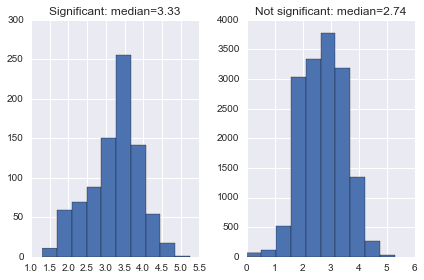

In [23]:
fig,axs = plt.subplots(1, 2)
ax = axs[0]
np.log10(combined_info.ix[sig_cnvs, 'length']).hist(ax=ax)
ax.set_title('Significant: median={:.2f}'.format(np.log10(combined_info.ix[sig_cnvs, 'length']).median()))
ax = axs[1]
np.log10(combined_info.ix[not_sig_cnvs, 'length']).hist()
ax.set_title('Not significant: median={:.2f}'.format(np.log10(combined_info.ix[not_sig_cnvs, 'length'].median())));
plt.tight_layout()

In [24]:
s,p = stats.mannwhitneyu(combined_info.ix[sig_cnvs, 'length'], 
                         combined_info.ix[not_sig_cnvs, 'length'])
print('CNVs with significant associations are longer than those without '
      'significant associations: p = {:.2e}'.format(p))
a = combined_info.ix[sig_cnvs, 'length'].median()
b = combined_info.ix[not_sig_cnvs, 'length'].median()
print('Sig median length = {}'.format(a))
print('Not sig median length = {}'.format(b))

CNVs with significant associations are longer than those without significant associations: p = 5.38e-76
Sig median length = 2125.0
Not sig median length = 550.0


### Distance to nearest TSS

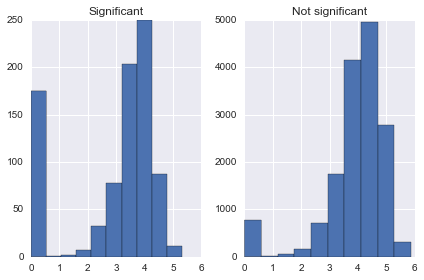

In [25]:
fig,axs = plt.subplots(1, 2)
ax = axs[0]
np.log10(combined_info.ix[sig_cnvs, 'nearest_tss_dist'].abs() + 1).hist(ax=ax)
ax.set_title('Significant')
ax = axs[1]
np.log10(combined_info.ix[not_sig_cnvs, 'nearest_tss_dist'].abs() + 1).hist()
ax.set_title('Not significant');
plt.tight_layout()

We can see that significant CNVs are typically closer to a TSS than CNVs
that are not signficant.

In [26]:
a = combined_info.ix[sig_cnvs, 'nearest_tss_dist'].abs()
b = combined_info.ix[not_sig_cnvs, 'nearest_tss_dist'].abs()
s,p = stats.mannwhitneyu(a, b)
print('CNVs with significant associations are closer to a TSS than those without '
      'significant associations: p = {:.2e}'.format(p))
print('Median distance to nearest TSS for sig CNVs: {:,}'.format(a.median()))
print('Median distance to nearest TSS for not sig CNVs: {:,}'.format(b.median()))

CNVs with significant associations are closer to a TSS than those without significant associations: p = 3.19e-109
Median distance to nearest TSS for sig CNVs: 3,605.0
Median distance to nearest TSS for not sig CNVs: 13,641.0


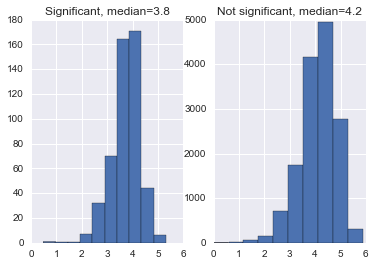

In [32]:
fig,axs = plt.subplots(1, 2)
ax = axs[0]
a = combined_info.ix[sig_cnvs - set(cnv_gv.ix[cnv_gv.cnv_overlaps_gene, 'cnv_id']), 'nearest_tss_dist'].abs()
a = a[a != 0]
np.log10(a.abs()).hist(ax=ax)
ax.set_title('Significant, median={:.1f}'.format(np.log10(a.abs()).median()))
ax = axs[1]
b = combined_info.ix[not_sig_cnvs, 'nearest_tss_dist'].abs()
b = b[b != 0]
ax.set_title('Not significant, median={:.1f}'.format(np.log10(b.abs()).median()))
np.log10(b.abs()).hist(ax=ax);

In [33]:
a = combined_info.ix[sig_cnvs - set(cnv_gv.ix[cnv_gv.cnv_overlaps_gene, 'cnv_id']), 'nearest_tss_dist'].abs()
a = a[a != 0]
b = combined_info.ix[not_sig_cnvs, 'nearest_tss_dist'].abs()
b = b[b != 0]
s,p = stats.mannwhitneyu(a, b)
print('Removing all CNVs that overlap any gene, CNVs with significant '
      'associations are closer to a TSS than those without '
      'significant associations: p = {:.2e}'.format(p))

Removing all CNVs that overlap any gene, CNVs with significant associations are closer to a TSS than those without significant associations: p = 1.44e-43


Even if we remove CNVs that overlap genes, the significant
CNVs are still closer to genes.

### Gene overlap

In [34]:
overlaps_sig = len(sig_cnvs & overlaps_gene)
overlaps_not_sig = len(not_sig_cnvs & overlaps_gene)
no_overlaps_sig = len(sig_cnvs) - overlaps_sig
no_overlaps_not_sig = len(not_sig_cnvs) - overlaps_not_sig
ctable = [[overlaps_sig, overlaps_not_sig], 
          [no_overlaps_sig, no_overlaps_not_sig]]
odds,p = stats.fisher_exact(ctable)
print('CNVs with significant association are enriched for '
      'overlapping a gene p={:.1e}'.format(p))

CNVs with significant association are enriched for overlapping a gene p=2.6e-33


## Intergenic CNV eQTLs

I'm going to look at CNV-eQTLs where the CNV doesn't overlap the affected gene.
This doesn't mean they are necessarily intergenic because they could overlap another gene,
but they don't overlap the gene they are associated with.

In [36]:
s = set(cnv_gv.ix[cnv_gv.cnv_overlaps_gene, 'gene_id'])
intergenic_cnv_gv = cnv_gv[cnv_gv.gene_id.apply(lambda x: x not in s)]

sig_intergenic_cnvs = set(intergenic_cnv_gv.cnv_id)
not_sig_cnvs = set(combined_info.index) - set(cnv_gv.cnv_id)

In [50]:
len(set(intergenic_cnv_gv.gene_id))

290

In [37]:
fn = os.path.join(ciepy.root, 'output/cnv_processing/combined_info.pickle')
combined_info = cPickle.load(open(fn))
combined_info = combined_info[combined_info.emmax]

In [40]:
promoters = pbt.BedTool('/publicdata/gencode_v19_20151104/promoters_by_gene.bed')
df = promoters.to_dataframe()
df['gene'] = df.name.apply(lambda x: x.split('_')[0])
df['region'] = df.name.apply(lambda x: x.split('_')[2])
df.index = df.region
gb = df.groupby('gene')
gene_to_promoters = gb.groups

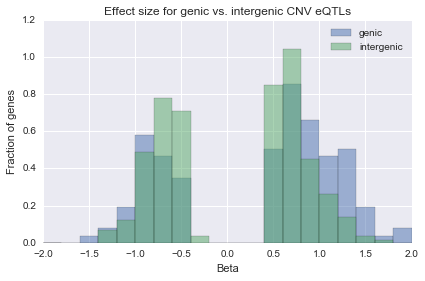

In [41]:
tdf = cnv_gv.sort_values(by=['cnv_overlaps_gene', 'pvalue'], 
                         ascending=[False, True]).drop_duplicates(subset=['gene_id'])
a = tdf[tdf.cnv_overlaps_gene]
b = tdf[tdf.cnv_overlaps_gene == False]
a.beta.hist(alpha=0.5, bins=np.arange(-2, 2.2, 0.2), normed=True, label='genic')
b.beta.hist(alpha=0.5, bins=np.arange(-2, 2.2, 0.2), normed=True, label='intergenic')
plt.title('Effect size for genic vs. intergenic CNV eQTLs')
plt.ylabel('Fraction of genes')
plt.xlabel('Beta')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(outdir, 'genic_vs_intergenic_beta.pdf'))

In [42]:
overlaps_sig = len(sig_intergenic_cnvs & overlaps_gene)
overlaps_not_sig = len(not_sig_cnvs & overlaps_gene)
no_overlaps_sig = len(sig_intergenic_cnvs) - overlaps_sig
no_overlaps_not_sig = len(not_sig_cnvs) - overlaps_not_sig
ctable = [[overlaps_sig, overlaps_not_sig], 
          [no_overlaps_sig, no_overlaps_not_sig]]
odds,p = stats.fisher_exact(ctable)
print('CNVs with significant association are enriched for '
      'overlapping a gene p={:.1e}'.format(p))

CNVs with significant association are enriched for overlapping a gene p=1.4e-07


While these CNVs don't overlap the gene that they are an eQTL for, they are still
enriched for overlapping some other gene.

In [56]:
roadmap_overlap = pd.concat([gs_roadmap_overlap, lumpy_roadmap_overlap])
roadmap_overlap = roadmap_overlap.ix[combined_info.index]

In [58]:
odds = []
pvalues = []
for c in roadmap_overlap.columns:
    vc = (roadmap_overlap.ix[sig_intergenic_cnvs, c] > 0).value_counts()
    sig_overlap = vc[True]
    sig_not_overlap = vc[False]
    vc = (roadmap_overlap.ix[not_sig_cnvs, c] > 0).value_counts()
    not_sig_overlap = vc[True]
    not_sig_not_overlap = vc[False]
    ctable = [[sig_overlap, sig_not_overlap], 
              [not_sig_overlap, not_sig_not_overlap]]
    o,p = stats.fisher_exact(ctable)
    odds.append(o)
    pvalues.append(p)
roadmap_res = pd.DataFrame({'odds':odds, 'pvalue':pvalues}, index=roadmap_overlap.columns)
colors = pd.DataFrame(zip(list(set([x.split('_')[-1] for x in roadmap_res.index])), 
                          cpb.analysis.tableau20[::2]), columns=['mark', 'color'])
roadmap_res['mark'] = [x.split('_')[-1] for x in roadmap_res.index]
roadmap_res['ind'] = roadmap_res.index
roadmap_res = roadmap_res.merge(colors)
roadmap_res.index = roadmap_res.ind
roadmap_res['log_odds'] = np.log2(roadmap_res.odds)
roadmap_res['neg_log_pvalue'] = -np.log10(roadmap_res.pvalue)

In [71]:
roadmap_res.to_csv(os.path.join(outdir, 'roadmap_res.tsv'), sep='\t')

TODO: limit to insignificant intergenic CNVs.

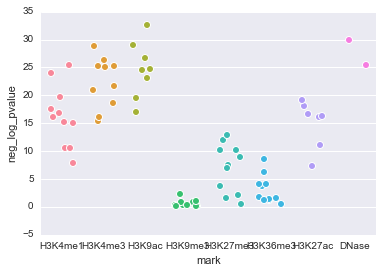

In [70]:
sns.stripplot(x='mark', y='neg_log_pvalue', data=roadmap_res, jitter=0.3)

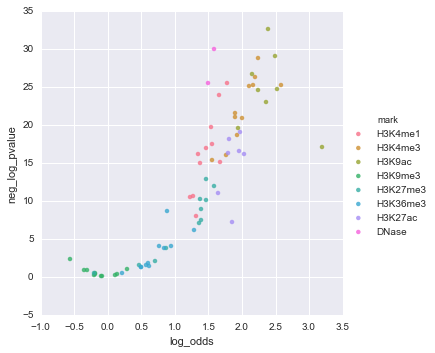

In [66]:
sns.lmplot(x='log_odds', y='neg_log_pvalue', data=roadmap_res, hue='mark', fit_reg=False)

In [63]:
roadmap_res.head()

,odds,pvalue,mark,ind,color,log_odds
ind,,,,,,
ES-I3_H3K4me1,2.745626,1.212193e-17,H3K4me1,ES-I3_H3K4me1,"(1.0, 0.498039215686, 0.0549019607843)",1.457135
ES-WA7_H3K4me1,2.490150,1.149746e-08,H3K4me1,ES-WA7_H3K4me1,"(1.0, 0.498039215686, 0.0549019607843)",1.316233
HUES48_H3K4me1,3.410467,3.105525e-26,H3K4me1,HUES48_H3K4me1,"(1.0, 0.498039215686, 0.0549019607843)",1.769969
HUES6_H3K4me1,2.583610,1.048671e-15,H3K4me1,HUES6_H3K4me1,"(1.0, 0.498039215686, 0.0549019607843)",1.369388
HUES64_H3K4me1,2.338544,2.813120e-11,H3K4me1,HUES64_H3K4me1,"(1.0, 0.498039215686, 0.0549019607843)",1.225610


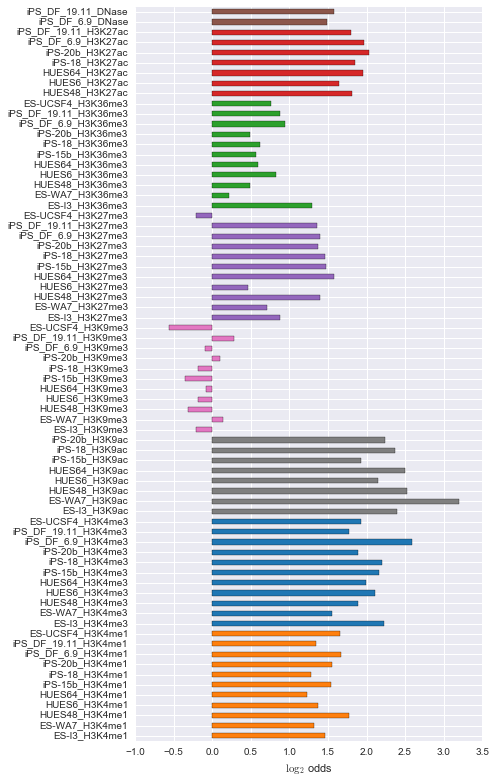

In [59]:
plt.figure(figsize=(7, 11))
(np.log2(roadmap_res.odds)).plot(kind='barh', color=roadmap_res.color)
plt.tight_layout()
plt.xlabel('$\log_2$ odds')
plt.ylabel('')
plt.tight_layout()
plt.savefig(os.path.join(outdir, 'intergenic_histone_mark_odds.pdf'))

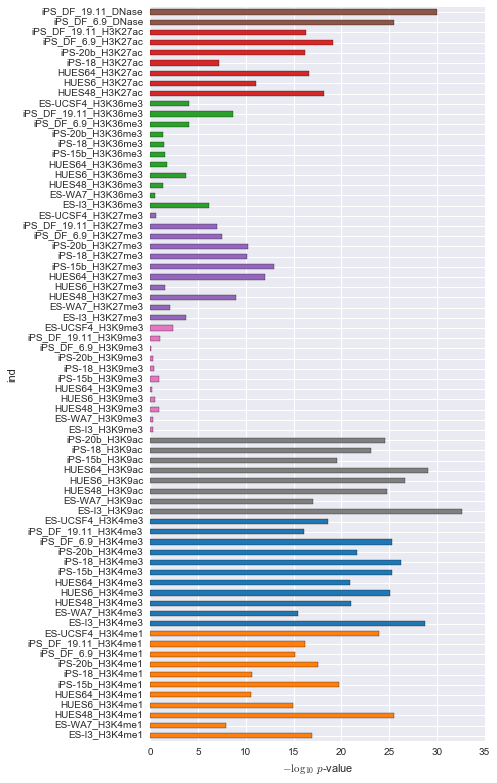

In [60]:
plt.figure(figsize=(7, 11))
(-np.log10(roadmap_res.pvalue)).plot(kind='barh', color=roadmap_res.color)
plt.xlabel('$-\log_{10}$ $p$-value')
plt.tight_layout()

In [36]:
odds = []
pvalues = []
for c in encode_dnase_overlap.columns:
    vc = (encode_dnase_overlap.ix[sig_intergenic_cnvs, c] > 0).value_counts()
    sig_overlap = vc[True]
    sig_not_overlap = vc[False]
    vc = (encode_dnase_overlap.ix[not_sig_cnvs, c] > 0).value_counts()
    not_sig_overlap = vc[True]
    not_sig_not_overlap = vc[False]
    ctable = [[sig_overlap, sig_not_overlap], 
              [not_sig_overlap, not_sig_not_overlap]]
    o,p = stats.fisher_exact(ctable)
    odds.append(o)
    pvalues.append(p)
encode_dnase_res = pd.DataFrame({'odds':odds, 'pvalue':pvalues}, index=encode_dnase_overlap.columns)

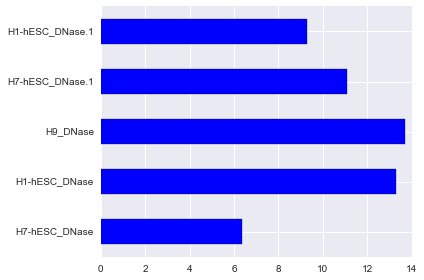

In [37]:
(-np.log10(encode_dnase_res.pvalue)).plot(kind='barh')
plt.tight_layout()

In [38]:
odds = []
pvalues = []
for c in encode_chip_overlap.columns:
    vc = (encode_chip_overlap.ix[sig_intergenic_cnvs, c] > 0).value_counts()
    if True not in vc.index:
        sig_overlap = 0
    else:
        sig_overlap = vc[True]
    sig_not_overlap = vc[False]
    vc = (encode_chip_overlap.ix[not_sig_cnvs, c] > 0).value_counts()
    if True not in vc.index:
        not_sig_overlap = 0
    else:
        not_sig_overlap = vc[True]
    not_sig_not_overlap = vc[False]
    ctable = [[sig_overlap, sig_not_overlap], 
              [not_sig_overlap, not_sig_not_overlap]]
    o,p = stats.fisher_exact(ctable)
    odds.append(o)
    pvalues.append(p)
encode_chip_res = pd.DataFrame({'odds':odds, 'pvalue':pvalues}, index=encode_chip_overlap.columns)
encode_chip_res.sort_values(by='pvalue', inplace=True, ascending=False)

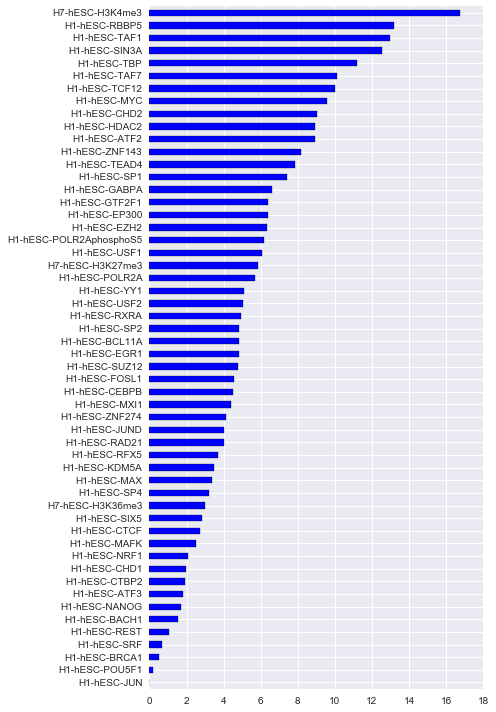

In [39]:
plt.figure(figsize=(7, 10))
(-np.log10(encode_chip_res.pvalue)).plot(kind='barh')
plt.tight_layout()

In [61]:
cnv_lead_vars['overlaps_gene'] = cnv_gv.ix[cnv_lead_vars.index, 'cnv_overlaps_gene']

In [ ]:
cnv_gv.ix['chr4:35240270-35244303:ENSG00000047365.7']

In [65]:
cnv_lead_vars.overlaps_gene

chr1:1637041-1638870:ENSG00000008128.18          True
chr4:35240270-35244303:ENSG00000047365.7          NaN
chr14:102637314-102639701:ENSG00000080824.14    False
chr1:16365505-16370349:ENSG00000080947.10         NaN
chr5:140222275-140228275:ENSG00000081842.13      True
chr1:108733342-108737242:ENSG00000085491.11      True
chr19:54728630-54736752:ENSG00000088038.13        NaN
chr19:54739008-54743710:ENSG00000088038.13        NaN
chr22:24325333-24331991:ENSG00000099991.12      False
chr22:24325333-24331991:ENSG00000099994.10      False
chr16:22599531-22603212:ENSG00000103404.10        NaN
chr11:17209714-17211214:ENSG00000110700.2         NaN
chr3:136021100-136026184:ENSG00000114054.9       True
chr6:132106570-132108770:ENSG00000118523.5      False
chr17:44327151-44330822:ENSG00000120071.8       False
chr1:147992889-147995447:ENSG00000122497.13     False
chr19:46817428-46818728:ENSG00000124440.11       True
chr7:75664281-75667842:ENSG00000127952.12        True
chr1:110230084-110232621:ENS

In [64]:
g = cnv_lead_vars.ix[cnv_lead_vars.overlaps_gene, 'gene_id']

ValueError: cannot index with vector containing NA / NaN values